# Income Expenses Prediction

## Import Libraries and Load Data

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [72]:
df = pd.read_csv('/Users/adrianacuppuleri/Library/Mobile Documents/com~apple~CloudDocs/GITHUB ADRIANA/Financial-Behavior-Prediction/data/2016-09-19_79351_training.csv')

In [73]:
df.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              408546 non-null  object 
 1   transaction_date     408546 non-null  object 
 2   transaction_type     408546 non-null  object 
 3   mcc_group            258324 non-null  float64
 4   amount_n26_currency  408546 non-null  int64  
 5   dataset_transaction  408546 non-null  object 
 6   dataset_user         408546 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 21.8+ MB


In [75]:
# Convert 'transaction_date' to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [76]:
df.amount_n26_currency.describe()

count    408546.000000
mean         52.764164
std         111.870681
min           3.000000
25%           7.000000
50%          17.000000
75%          38.000000
max        1166.000000
Name: amount_n26_currency, dtype: float64

## Data Exploration

In [77]:
df['transaction_type'].value_counts()

transaction_type
PT     258324
CT      63837
DT      40528
DD      29869
FT       6528
DR       4727
BBU      3561
BUB       942
TUB       230
Name: count, dtype: int64

In [78]:
df['mcc_group'].value_counts(dropna=False).sort_values()
#the group with highest value counts is NaN

mcc_group
14.0        24
13.0       141
9.0        287
15.0       329
12.0       873
5.0       3337
11.0      5803
10.0      7282
7.0      10888
16.0     11150
17.0     11466
4.0      20194
8.0      20610
3.0      20875
6.0      24672
2.0      50586
1.0      69807
NaN     150222
Name: count, dtype: int64

In [79]:
#for clarity, I add a col with correspondent categories of mcc_group
mcc_group_mapping = {
    1: 'ATM',
    2: 'Groceries',
    3: 'Gastronomie',
    4: 'Shopping/(Fashion)',
    5: 'Home and DIY, House Energy',
    6: 'Travel/Hotel',
    7: 'Transport',
    8: 'Automotive/Gas',
    9: 'Family/Babies/Children',
    10: 'Entertainment/Leisure',
    11: 'Drugstore',
    12: 'Finance',
    13: 'Insurance',
    14: 'Taxes and Fines',
    15: 'Education',
    16: 'Miscellaneous',
    17: 'Business Expenses'
}

# Create a new column 'mcc_group_category' by mapping mcc_group to category name
df['mcc_group_category'] = df['mcc_group'].map(mcc_group_mapping)

# Fill in the NA values with 'NA' for missing mcc_group
df.fillna({'mcc_group_category':'NA'}, inplace=True)

In [80]:
df[['mcc_group', 'mcc_group_category']].value_counts(dropna=False).sort_index()

mcc_group  mcc_group_category        
1.0        ATM                            69807
2.0        Groceries                      50586
3.0        Gastronomie                    20875
4.0        Shopping/(Fashion)             20194
5.0        Home and DIY, House Energy      3337
6.0        Travel/Hotel                   24672
7.0        Transport                      10888
8.0        Automotive/Gas                 20610
9.0        Family/Babies/Children           287
10.0       Entertainment/Leisure           7282
11.0       Drugstore                       5803
12.0       Finance                          873
13.0       Insurance                        141
14.0       Taxes and Fines                   24
15.0       Education                        329
16.0       Miscellaneous                  11150
17.0       Business Expenses              11466
NaN        NA                            150222
Name: count, dtype: int64

### Data Visualization

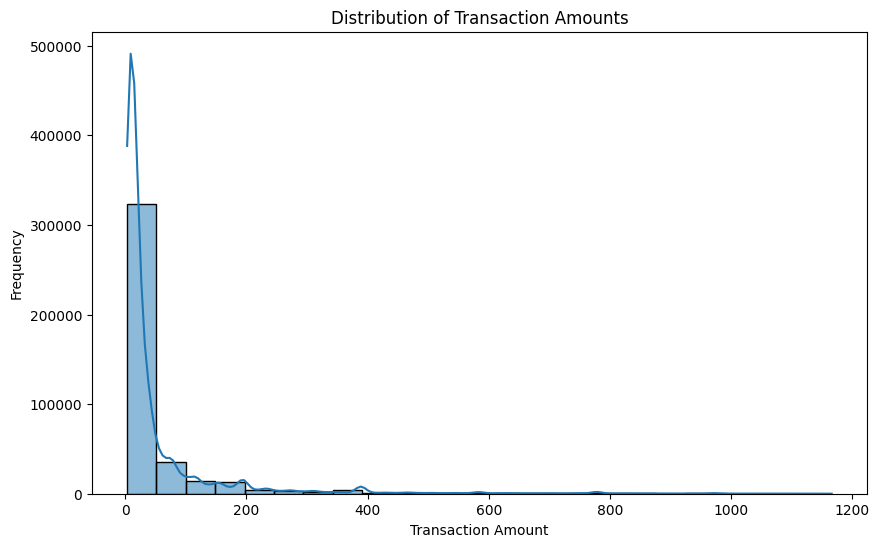

In [81]:
# distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount_n26_currency'], bins=24, kde=True)

plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

#The bulk of the transactions seem to be clustered in the range of 0 to around 50 units.

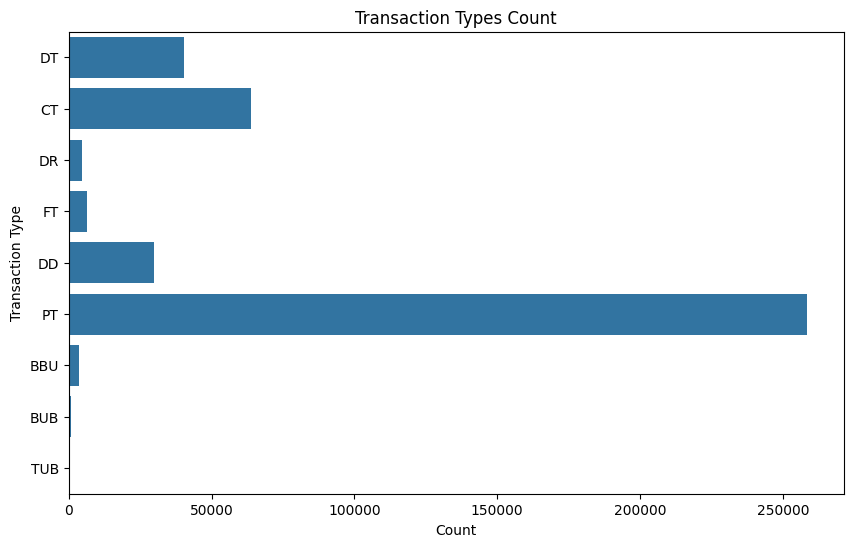

In [82]:
#the count of each transaction type
plt.figure(figsize=(10, 6))
sns.countplot(y='transaction_type', data=df)

plt.title('Transaction Types Count')
plt.xlabel('Count')
plt.ylabel('Transaction Type')
plt.show()

#PT (Presentment) has the highest count

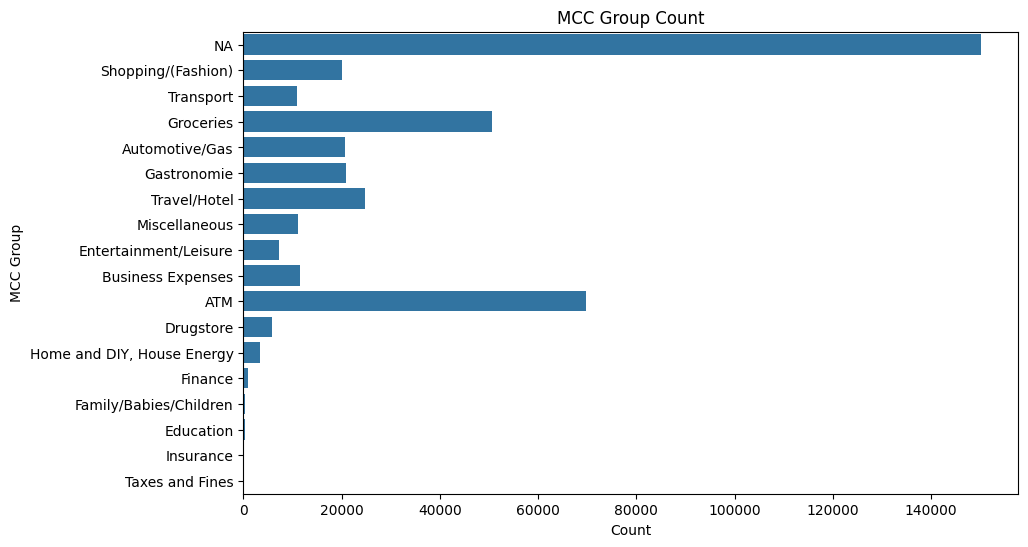

In [83]:
#the count of transactions per MCC group
plt.figure(figsize=(10, 6))
sns.countplot(y='mcc_group_category', data=df)

plt.title('MCC Group Count')
plt.xlabel('Count')
plt.ylabel('MCC Group')
plt.show()

In [84]:
#time-series exploration
# Group by month and sum the transaction amounts
monthly_transactions = df.groupby(df['transaction_date'].dt.to_period('M'))['amount_n26_currency'].sum()
monthly_transactions

transaction_date
2016-02    3118699
2016-03    3577873
2016-04    3628088
2016-05    3715338
2016-06    3710907
2016-07    3805683
Freq: M, Name: amount_n26_currency, dtype: int64

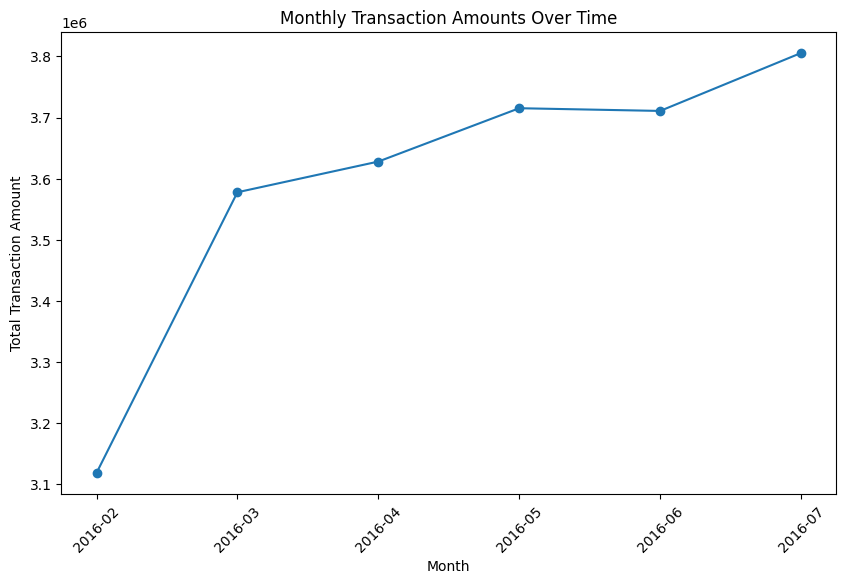

In [89]:
# Monthly aggregation by transaction amount
df['month'] = df['transaction_date'].dt.to_period('M')
monthly_agg = df.groupby('month')['amount_n26_currency'].sum().reset_index()
monthly_agg['month'] = monthly_agg['month'].astype(str)

# Line plot of monthly aggregated transaction amounts
plt.figure(figsize=(10, 6))
plt.plot(monthly_agg['month'], monthly_agg['amount_n26_currency'], marker='o')
plt.title('Monthly Transaction Amounts Over Time')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.xticks(rotation=45)
plt.show()

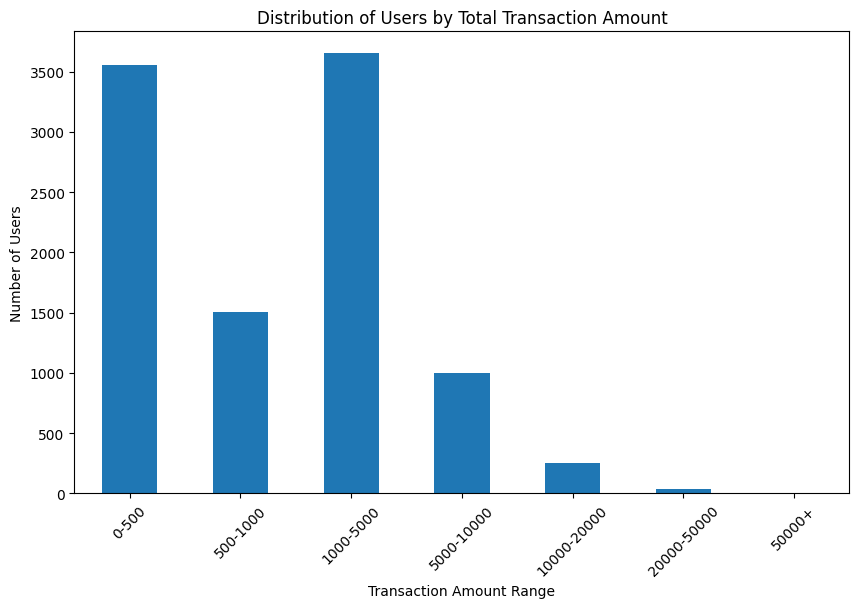

In [87]:
# Aggregate transaction amount per user
user_agg = df.groupby('user_id')['amount_n26_currency'].sum().reset_index()
bins = [0, 500, 1000, 5000, 10000, 20000, 50000, 100000]
labels = ['0-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-50000', '50000+']
user_agg['amount_bin'] = pd.cut(user_agg['amount_n26_currency'], bins=bins, labels=labels, include_lowest=True)
bin_counts = user_agg['amount_bin'].value_counts().sort_index()

# barplot for user-based outliers
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar')
plt.title('Distribution of Users by Total Transaction Amount')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

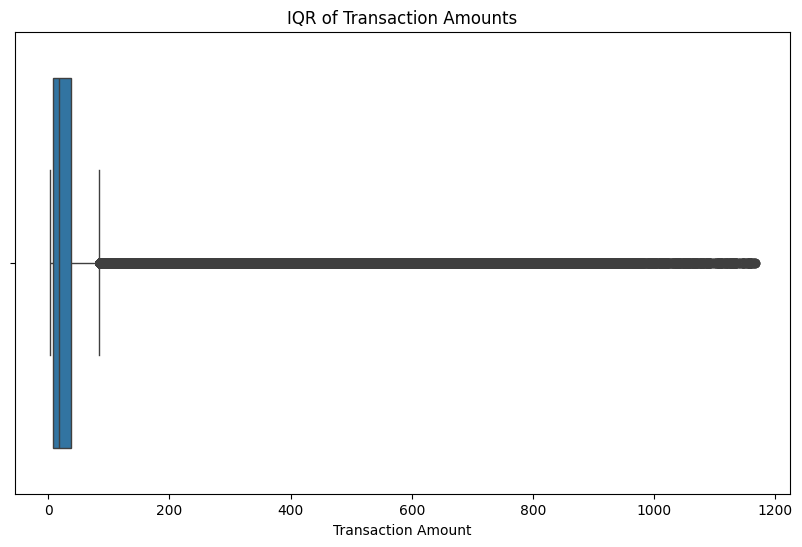

In [70]:
#IQR of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['amount_n26_currency'])
plt.title('IQR of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

In [90]:
# divide transactions into expense and income
transaction_classification = {
    'PT': 'Expense',
    'DD': 'Expense',
    'DR': 'Income',
    'CT': 'Income',
    'FT': 'Expense',
    'BBU': 'Income',
    'BUB': 'Expense',
    'DT': 'Income',
    'TUB': 'Expense'
}

df['transaction_flow'] = df['transaction_type'].map(transaction_classification)

In [91]:
# Group the data by 'month' and 'transaction_flow' (Income/Expense) and sum the amounts
monthly_totals = df.groupby(['month', 'transaction_flow'])['amount_n26_currency'].sum().unstack()

# Fill any missing values with 0 (if some months don't have income or expenses)
monthly_totals.fillna(0, inplace=True)

In [92]:
monthly_totals['Income']

month
2016-02    2031898
2016-03    2280448
2016-04    2319689
2016-05    2317467
2016-06    2336558
2016-07    2365555
Freq: M, Name: Income, dtype: int64

In [93]:
monthly_totals['Expense']

month
2016-02    1086801
2016-03    1297425
2016-04    1308399
2016-05    1397871
2016-06    1374349
2016-07    1440128
Freq: M, Name: Expense, dtype: int64

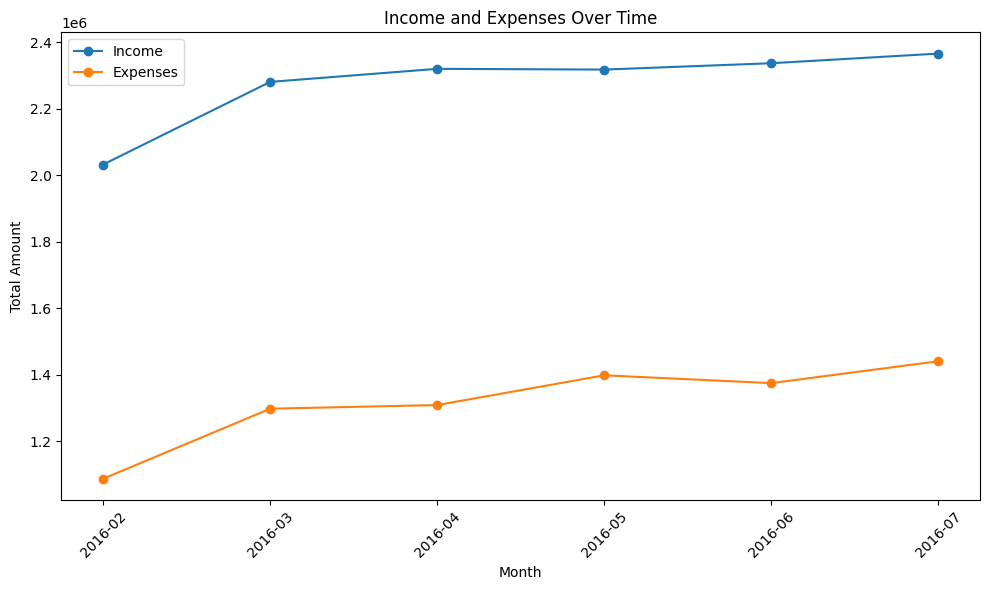

In [94]:
#  income and expenses over months
plt.figure(figsize=(10, 6))
# 
plt.plot(monthly_totals.index.astype(str), monthly_totals['Income'], label='Income', marker='o')

# Plot Expenses
plt.plot(monthly_totals.index.astype(str), monthly_totals['Expense'], label='Expenses', marker='o')

# Adding titles and labels
plt.title('Income and Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Data Preprocessing

### Handling Missing values and duplicates

In [95]:
print(df.isnull().sum())

user_id                     0
transaction_date            0
transaction_type            0
mcc_group              150222
amount_n26_currency         0
dataset_transaction         0
dataset_user                0
mcc_group_category          0
transaction_flow            0
month                       0
dtype: int64


In [96]:
#Is there a relationship between the missing mcc_group values and other columns?
cross_tab = pd.crosstab(df['transaction_type'], df['mcc_group_category'])
cross_tab

mcc_group_category,ATM,Automotive/Gas,Business Expenses,Drugstore,Education,Entertainment/Leisure,Family/Babies/Children,Finance,Gastronomie,Groceries,"Home and DIY, House Energy",Insurance,Miscellaneous,NA,Shopping/(Fashion),Taxes and Fines,Transport,Travel/Hotel
transaction_type,,,,,,,,,,,,,,,,,,
BBU,0,0,0,0,0,0,0,0,0,0,0,0,0,3561,0,0,0,0
BUB,0,0,0,0,0,0,0,0,0,0,0,0,0,942,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,63837,0,0,0,0
DD,0,0,0,0,0,0,0,0,0,0,0,0,0,29869,0,0,0,0
DR,0,0,0,0,0,0,0,0,0,0,0,0,0,4727,0,0,0,0
DT,0,0,0,0,0,0,0,0,0,0,0,0,0,40528,0,0,0,0
FT,0,0,0,0,0,0,0,0,0,0,0,0,0,6528,0,0,0,0
PT,69807,20610,11466,5803,329,7282,287,873,20875,50586,3337,141,11150,0,20194,24,10888,24672
TUB,0,0,0,0,0,0,0,0,0,0,0,0,0,230,0,0,0,0


In [97]:
# Create the crosstab comparing transaction_flow with mcc_group_category
income_expense_crosstab = pd.crosstab(df['transaction_flow'], df['mcc_group_category'])
income_expense_crosstab

mcc_group_category,ATM,Automotive/Gas,Business Expenses,Drugstore,Education,Entertainment/Leisure,Family/Babies/Children,Finance,Gastronomie,Groceries,"Home and DIY, House Energy",Insurance,Miscellaneous,NA,Shopping/(Fashion),Taxes and Fines,Transport,Travel/Hotel
transaction_flow,,,,,,,,,,,,,,,,,,
Expense,69807,20610,11466,5803,329,7282,287,873,20875,50586,3337,141,11150,37569,20194,24,10888,24672
Income,0,0,0,0,0,0,0,0,0,0,0,0,0,112653,0,0,0,0


In [98]:
# For non-PT transactions assign Bank Transaction to CT, DT, DD, FT, and DR, which are typical bank-related transactions.
# and Partner Transaction to BBU, BUB, and TUB, which seem to involve partners.
# Label non-card transactions as 'Bank Transaction' and 'Partner Transaction'

non_card_bank_types = ['CT', 'DT', 'DD', 'FT', 'DR']  # Bank-related transactions
partner_types = ['BBU', 'BUB', 'TUB']  # Partner-related transactions

# Apply labeling to category
df['mcc_group_category'] = df.apply(lambda x: 'Bank Transaction' if x['transaction_type'] in non_card_bank_types else 
                           ('Partner Transaction' if x['transaction_type'] in partner_types else x['mcc_group_category']), axis=1)

# Apply labeling: assign 18 for Bank Transactions and 19 for Partner Transactions
df['mcc_group'] = df.apply(lambda x: 18 if x['transaction_type'] in non_card_bank_types else 
                           (19 if x['transaction_type'] in partner_types else x['mcc_group']), axis=1)


In [99]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              408546 non-null  object        
 1   transaction_date     408546 non-null  datetime64[ns]
 2   transaction_type     408546 non-null  object        
 3   mcc_group            408546 non-null  float64       
 4   amount_n26_currency  408546 non-null  int64         
 5   dataset_transaction  408546 non-null  object        
 6   dataset_user         408546 non-null  object        
 7   mcc_group_category   408546 non-null  object        
 8   transaction_flow     408546 non-null  object        
 9   month                408546 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 31.2+ MB
user_id                0
transaction_date       0
transaction_type       0
mcc_group             

In [100]:
df[['mcc_group', 'mcc_group_category']].value_counts().sort_index()

mcc_group  mcc_group_category        
1.0        ATM                            69807
2.0        Groceries                      50586
3.0        Gastronomie                    20875
4.0        Shopping/(Fashion)             20194
5.0        Home and DIY, House Energy      3337
6.0        Travel/Hotel                   24672
7.0        Transport                      10888
8.0        Automotive/Gas                 20610
9.0        Family/Babies/Children           287
10.0       Entertainment/Leisure           7282
11.0       Drugstore                       5803
12.0       Finance                          873
13.0       Insurance                        141
14.0       Taxes and Fines                   24
15.0       Education                        329
16.0       Miscellaneous                  11150
17.0       Business Expenses              11466
18.0       Bank Transaction              145489
19.0       Partner Transaction             4733
Name: count, dtype: int64

In [101]:
duplicates = df.duplicated()
duplicates.sum()
df[duplicates]

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,mcc_group_category,transaction_flow,month
52,d676b47c24ee99835d24e38953cf7ab6,2016-02-01,DT,18.0,15,training,training,Bank Transaction,Income,2016-02
70,ce8150cf1461297516d4f65d8258a36b,2016-02-01,DT,18.0,5,training,training,Bank Transaction,Income,2016-02
84,ce8150cf1461297516d4f65d8258a36b,2016-02-01,DT,18.0,5,training,training,Bank Transaction,Income,2016-02
93,ea589a947c4c128a6c6b81fb35605d40,2016-02-01,DT,18.0,5,training,training,Bank Transaction,Income,2016-02
102,dc879d41982dfa14abb14d96818eadd2,2016-02-01,DT,18.0,19,training,training,Bank Transaction,Income,2016-02
...,...,...,...,...,...,...,...,...,...,...
408296,dd99d81a087d354cc6131ec386800d22,2016-07-31,DT,18.0,19,training,training,Bank Transaction,Income,2016-07
408300,b6caa44ddab07f100ad5fc4927fd563e,2016-07-31,PT,1.0,19,training,training,ATM,Expense,2016-07
408307,c00d31436e6a8aabc179b8f138a3ffd4,2016-07-31,PT,1.0,194,training,training,ATM,Expense,2016-07
408493,3967d1c646a5c68aa3e64294cd77b263,2016-07-31,DT,18.0,5,training,training,Bank Transaction,Income,2016-07


In [102]:
df_cleaned = df.drop_duplicates()
df_cleaned.info()
print(df_cleaned.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 398321 entries, 0 to 408545
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              398321 non-null  object        
 1   transaction_date     398321 non-null  datetime64[ns]
 2   transaction_type     398321 non-null  object        
 3   mcc_group            398321 non-null  float64       
 4   amount_n26_currency  398321 non-null  int64         
 5   dataset_transaction  398321 non-null  object        
 6   dataset_user         398321 non-null  object        
 7   mcc_group_category   398321 non-null  object        
 8   transaction_flow     398321 non-null  object        
 9   month                398321 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 33.4+ MB
user_id                0
transaction_date       0
transaction_type       0
mcc_group              0
am

### Handling Cat var

## Time Series Analysis

### ARIMA model

### ETS